# Shape approximation of a spherical-cap bubble

## Outline

1. [Starting point](#starting_point)
2. [Volume-of-fluid data](#vof_data)
3. [Parameterization](#parameterization)
4. [Simple function approximation](#function_approximation)
5. [Direct approximation of the radius](#direct_approximation)
6. [Using prior/domain knowledge](#prior_knowledge)
    1. [Re-scaling the data](#rescaling)
    2. [Adding artificial data](#artificial_data)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>



In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
matplotlib.rcParams['figure.dpi'] = 80

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))

Pandas version: 0.24.2
Numpy version: 1.16.2
PyTorch version: 1.0.0
Running notebook locally.


## Volume-of-fluid data<a id="vof_data"></a>

In [2]:
if not IN_COLAB:
    data_file = "../data/bhaga_03_l16.csv"
else:
    data_file = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/bhaga_03_l16.csv"
data = pd.read_csv(data_file, header=0)
print("The data set contains {} points.".format(data.shape[0]))
data.head()

The data set contains 1170 points.


,px,py
0,-0.157689,0.596598
1,-0.157689,0.596924
2,-0.157689,0.596924
3,-0.158289,0.600586
4,-0.158289,0.600586


<IPython.core.display.Javascript object>


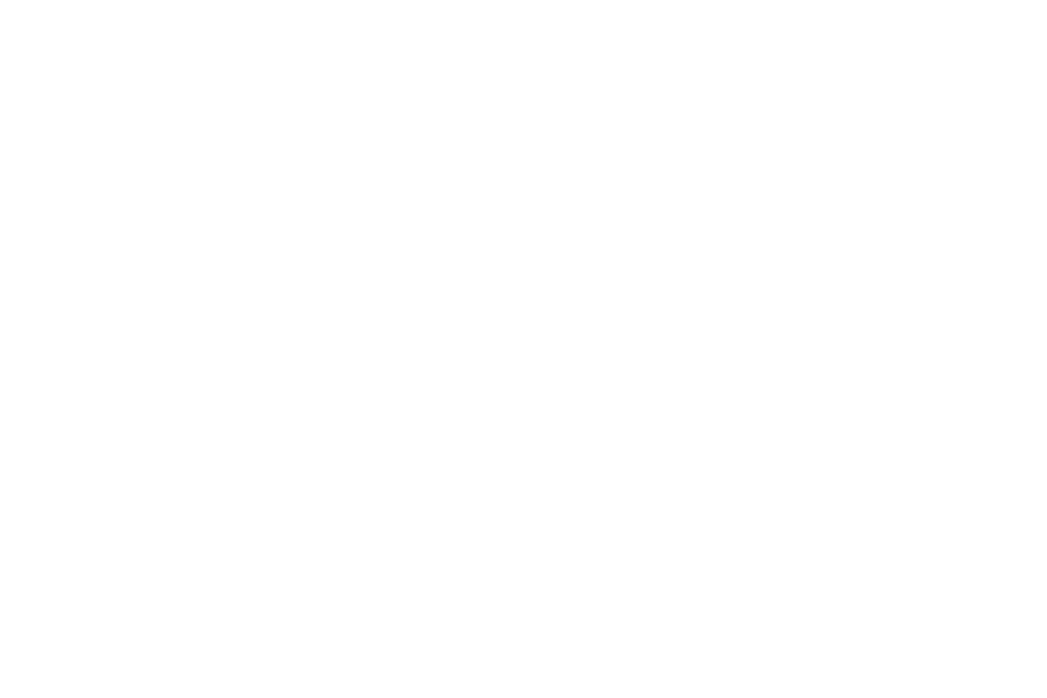

In [3]:
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib notebook
    
fontsize = 14

fig, ax = plt.subplots(figsize=(12, 8))

line_segments = [[(data.py[i], data.px[i]),(data.py[i+1], data.px[i+1])] for i in range(0, data.shape[0] - 1, 2) ]
lc = mc.LineCollection(line_segments, linewidths=1, colors='k')
ax.add_collection(lc)
ax.autoscale()

x = [i[0] for j in line_segments for i in j]
y = [i[1] for j in line_segments for i in j]
ax.scatter(x, y, marker='x', color='k', s=30, linewidth=0.5)

ax.set_aspect('equal')
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$y$", fontsize=fontsize)
ax.set_xlim(0.0, 0.9)
plt.show()

## Parameterization<a id="parameterization"></a>

In [4]:
def polar_coordinates(px, py):
    '''Converts raduis from Cartesian coordinates r(x,y) to polar coordinates r(phi)
    
    Parameters
    ----------
    px, py - array-like: x and y coordinates of PLIC points
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like: polar angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py))
    phi = np.arccos(py / radius)
    return radius, phi

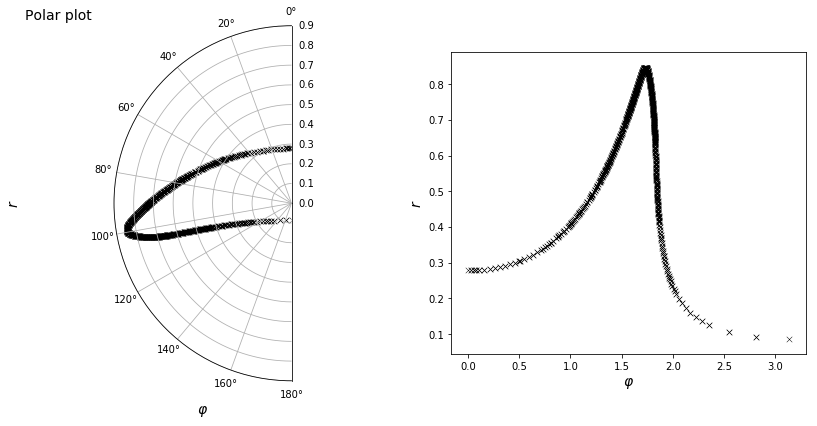

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)

radius, phi = polar_coordinates(data.py, data.px)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax1.set_xlim(0.0, np.pi)
ax1.set_title("Polar plot", loc='left', fontsize=fontsize)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax2.set_aspect(asp)
    
plt.show()

## Simple function approximation<a id="function_approximation"></a>

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [20]:
def approximate_function(x, y, model, l_rate=0.001, max_iter=1000, path=None, verbose=100):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x - array-like    : argument of the function
    y - array-like    : function value at x
    model - SimpleMLP : PyTorch model which is adjusted to approximate the function
    l_rate - Float    : learning rate for weight optimization
    max_iter - Integer: maximum number of allowed training epochs
    path - String     : location to save model weights
    verbose - Integer : defines frequency for loss information output
    
    Returns
    -------
    model - SimpleMLP: trained version of the given model
    
    '''
    # convert coordinates to torch tensors
    x_tensor = torch.from_numpy(x).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y)
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    
    # training loop
    best_loss = 1.0E5
    count = 0
    for e in range(1, max_iter+1):
        # backpropagation
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        loss = criterion(output.squeeze(dim=1), y_tensor)
        loss.backward()
        optimizer.step()
        # check error
        diff = output.squeeze(dim=1) - y_tensor
        max_diff = np.amax(np.absolute(diff.detach().numpy()))
        if loss.item() < best_loss:
            count += 1
            best_loss = loss.item()
            if count % verbose == 0:
                print("Loss/max. dev. decreased in epoch {}: {}/{}".format(e, loss.item(), max_diff))
            if path is not None:
                if count % verbose == 0: print("Saving model as {}".format(path))
                torch.save(model.state_dict(), path)
    return model.eval()

In [21]:
def set_path(name=None):
    if IN_COLAB:
        return F"/content/gdrive/My Drive/" + name
    else:
        return "models/" + name

## Direkt approximation of the radius<a id="direct_approximation"></a>

In [22]:
radius_model_direct = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_direct = approximate_function(phi.values, radius.values, radius_model_direct, max_iter=1500,
                                           l_rate=0.01, path=set_path("radius_model_direct.pt"))

Loss/max. dev. decreased in epoch 202: 0.02150745592818907/0.5868080199605488
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 357: 0.0001771959482995123/0.07677362844538617
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 694: 0.0001462909176906388/0.08561022134549591
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 794: 0.0001405876218503546/0.08629865085449183
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1046: 0.00013645239463167986/0.08670338561569034
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1311: 0.00013299358328777534/0.08724656917301614
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1411: 0.00012973295807208594/0.08600548024288725
Saving model as models/radius_model_direct.pt


Maximum relative deviation: 98.50% at angle 3.14.


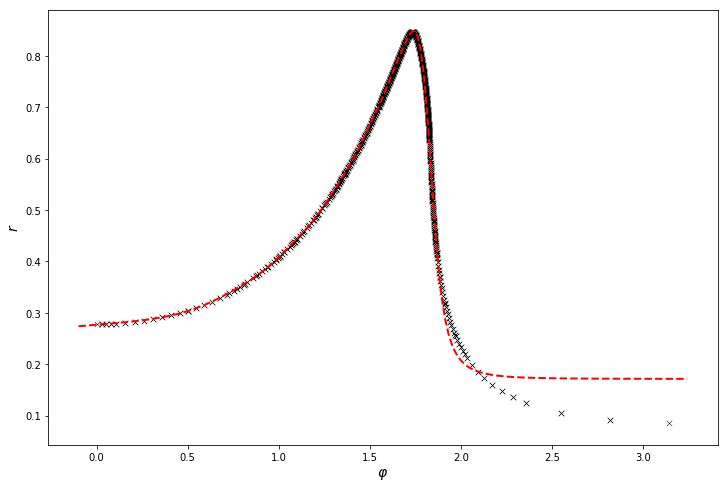

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

eval_phi = np.linspace(-0.1, np.pi+0.1, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
# load best weights and compute forward pass
radius_model_direct.load_state_dict(torch.load(set_path("radius_model_direct.pt")))
model_radius = radius_model_direct.forward(phi_tensor).detach().squeeze().numpy()
phi_data_tensor = torch.from_numpy(phi.values).unsqueeze_(-1)
# evaluate maximum relative deviation
model_radius_data = radius_model_direct.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius.values)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius.values[diff_max_pos] * 100, phi.values[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

## Using prior/domain knowledge<a id="prior_knowledge"></a>

### Re-scaling the data<a id="rescaling"></a>

The variance of the original radius is 0.0307.
The variance of the scaled radius is 0.0046.


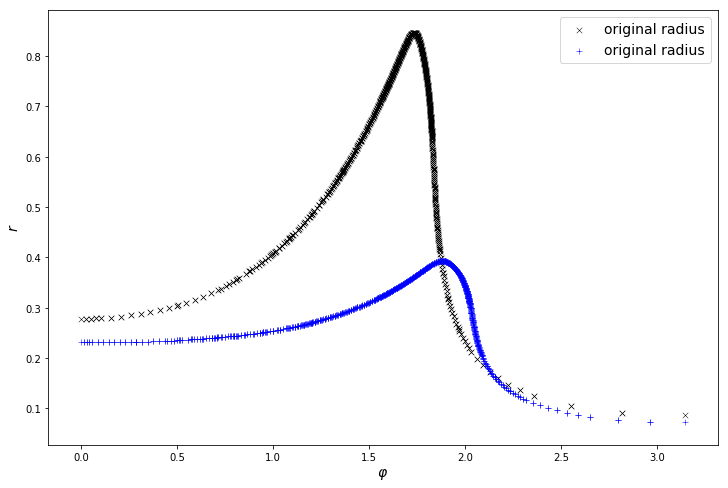

In [25]:
px_scaled = data.px.values * abs(np.amax(data.py.values) - np.amin(data.py.values))
py_scaled = data.py.values * abs(np.amax(data.px.values) - np.amin(data.px.values))

radius_scaled, phi_scaled = polar_coordinates(py_scaled, px_scaled)

print("The variance of the original radius is {:1.4f}.".format(np.var(radius.values)))
print("The variance of the scaled radius is {:1.4f}.".format(np.var(radius_scaled)))

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5, label=r"original radius")
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5, label=r"original radius")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [26]:
radius_model_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_scaled = approximate_function(phi_scaled, radius_scaled, radius_model_scaled, max_iter=1500,
                                           l_rate=0.01, path=set_path("radius_model_scaled.pt"))

Loss/max. dev. decreased in epoch 225: 0.004608937133709012/0.22924771450966225
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 327: 0.003881179735356414/0.24542921346454438
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 427: 0.003859523812694506/0.2446746595699597
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 527: 0.00385534204623278/0.24458782238522808
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 699: 1.0538506353300101e-05/0.021985334232512838
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 799: 9.098867702890472e-06/0.019294586444266765
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 899: 7.795782629986184e-06/0.01750370320951057
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1074: 5.805590530469129e-06/0.01565225911063102
Saving model as models/radius_mo

Maximum relative deviation: 10.47% at angle 2.96.


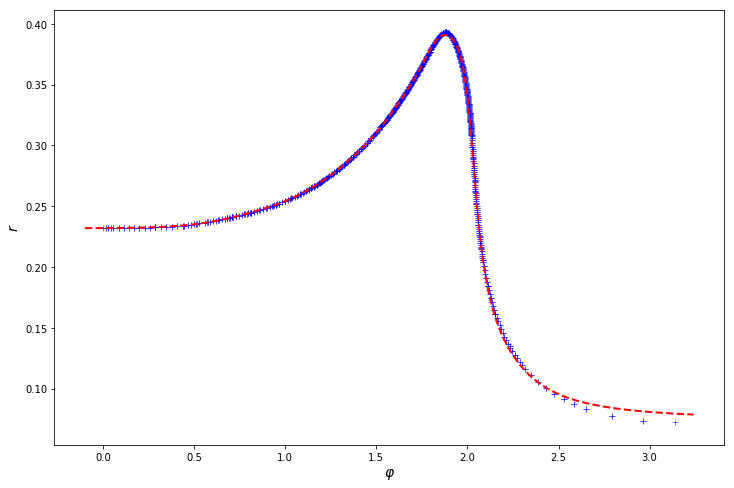

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
radius_model_scaled.load_state_dict(torch.load(set_path("radius_model_scaled.pt")))
model_radius = radius_model_scaled.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_scaled.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

### Adding artificial data<a id="artificial_data"></a>

In [13]:
phi_threshold = 0.5
phi_add = []
radius_add = []

for p, r in zip(phi_scaled, radius_scaled):
    if p < phi_threshold:
        phi_add.append(-p)
        radius_add.append(r)
    if p > np.pi - phi_threshold:
        phi_add.append(2 * np.pi - p)
        radius_add.append(r)
        
phi_extended = np.concatenate((phi_scaled, np.asarray(phi_add)))
radius_extended = np.concatenate((radius_scaled, np.asarray(radius_add)))
print("Added {} points to the training data.".format(radius_extended.shape[0] - radius_scaled.shape[0]))

Added 52 points to the training data.


In [28]:
radius_model_extended = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_extended = approximate_function(phi_extended, radius_extended, radius_model_extended, max_iter=1500,
                                             l_rate=0.01, path=set_path("radius_model_extended.pt"))

Loss/max. dev. decreased in epoch 241: 0.004859075782205516/0.2254169782019977
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 341: 0.004855047607339516/0.2255087968462008
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 441: 0.004745274157923639/0.22710022062942714
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 541: 0.004033017282836334/0.24235730265334243
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 641: 0.0039558515753499515/0.24061816300012562
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 748: 4.4692681971504637e-05/0.05168029333802894
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 849: 5.047957965290931e-06/0.018291510891235402
Saving model as models/radius_model_extended.pt
Loss/max. dev. decreased in epoch 1011: 1.0557062576797143e-06/0.008606784862773886
Saving model as m

Maximum relative deviation: 6.43% at angle 3.14.


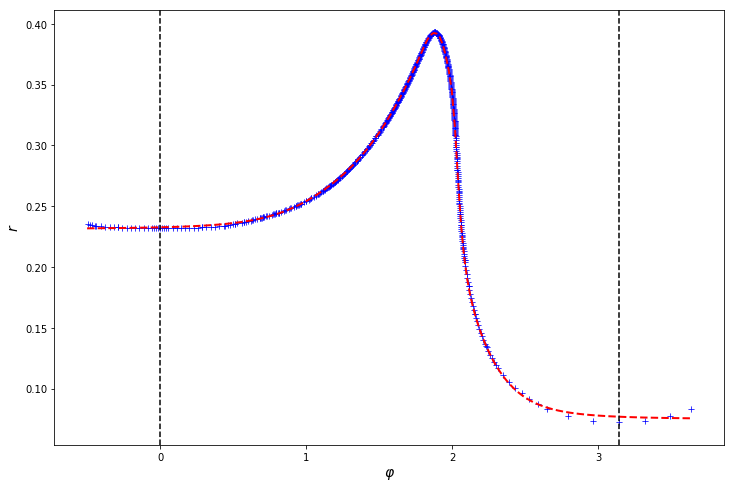

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
eval_phi = np.linspace(-0.5, np.pi+0.5, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
radius_model_extended.load_state_dict(torch.load(set_path("radius_model_extended.pt")))
model_radius = radius_model_extended.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation (only in 0...pi)
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_extended.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_extended, radius_extended, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.axvline(0.0, 0.0, 1.0, color='k', linestyle='--')
ax.axvline(np.pi, 0.0, 1.0, color='k', linestyle='--')
plt.show()

## Final notes<a id="final_notes"></a>

- play around with the number of layers and neurons per layer
- many layers, sigmoid suffers from vanishing gradient, change activation function, e.g., to *torch.relu*
- create a custom loss funtion that weights each individual inversly to the distribution of the training data over the polar angle.